# Differentially Private MNIST

In [6]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Setup

First, we clone the tensorflow/models repository. This cell may take a notable amount of time to run, because the repository is quite large.

In [7]:
! git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [8]:
! ln -s models/research/differential_privacy differential_privacy

ln: differential_privacy/differential_privacy: File exists


# Introduction

This notebook walks through an example of a differentially private stochastic gradient descent. The original code can be accessed at this link:

https://github.com/tensorflow/models/tree/master/research/differential_privacy 

The code has been modified to illustrate the examples, and to integrate with the notebook more easily. This notebook provdes a high-level overview of differentially private stochastic gradient descent.

Deep neural networks  (DNNs) are powerful techniques for regression and classification tasks, but they are not perfect. Aside from long training times and a nontrival theoretical background, they also have a tendency to overfit to their data. As a consequence, malicious third-parties (also known as adversaries) can reverse-engineer a DNN's training data. This threat is impeded by differential privacy. 

In particular, the use of differentially private stochastic gradient descent produces DNNs that do not overfit as easily. In fact, differentially private machine learning models often generalize better than nonprivate models (Abadi et al., 2016).

In [4]:
%matplotlib inline
from __future__ import division

import os
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from differential_privacy.dp_sgd.dp_optimizer import dp_optimizer
from differential_privacy.dp_sgd.dp_optimizer import dp_pca
from differential_privacy.dp_sgd.dp_optimizer import sanitizer
from differential_privacy.dp_sgd.dp_optimizer import utils
from differential_privacy.privacy_accountant.tf import accountant

In [5]:
# Suppress TensorFlow debugging logs.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.WARN)

# Main Code

## Configuration

This object (FlagSettings) also includes some model hyperparameters.

In [6]:
from settings import FlagSettings
FLAGS = FlagSettings(preserve_privacy=True)

## Downloading data

We need to download and preprocess the MNIST dataset for this notebook to work. Fortunately, TensorFlow also provides a script that downloads and preprocesses conveniently. It is included in this repository. 

NOTE: This script below will download the MNIST files into your /tmp/ folder. To change the download destination, go into settings.py and adjust the default value in the __\_\_init\_\___ function, or change the variable '__FLAGS.data_dir__' on your own in this notebook.

In [7]:
! python3 models/research/slim/download_and_convert_data.py --dataset_name=mnist --dataset_dir={FLAGS.data_dir}

Dataset files already exist. Exiting without re-creating them.


## Reading the input files

** This function reads in the MNIST data files, which you downloaded above. A queue is used to order all the batches of the data. This way, if multiple processes are spun up in a forward pass, identical batches are not passed in twice.

In [8]:
from utils import MnistInput, Eval, Validate, CreateModel, BoundGradients

# Private SGD

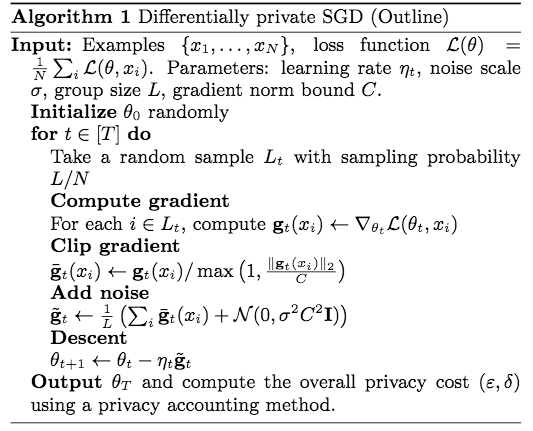

We use this algorithm at a high-level in this notebook.
The above image shows pseudo-code for the differentially private stochastic gradient descent algorithm, taken directly from "Deep Learning with Differential Privacy" by Abadi et al. (2016). 

There are many variants on the classic stochastic gradient descent, so in a sense this algorithm is not as esoteric as it may initially appear. The key to this method's differential privacy guarantee relies on the noise injection , the __Add Noise__ section, before the __Descent__.

## Privacy Accountant

In this notebook, a privacy accountant is an object that computes and stores the growing privacy budget of a differentially private computation. Interestingly, Abadi et al. use a novel method to aggregate the privacy levels.

Abadi et al. present the "Moments Accountant". The idea is "by tracking detailed information (higher moments) of the privacy loss, we can obtain much tighter estiamtes on the overall privacy loss, both asymptotically and empiricially". However, this notebook uses the "Amortized Accountant" for simplicity.

The Amortized Accountant computes the privacy budget using an improved composition theorem, similar to the Moments accountant. The source code can be found at this link: 
https://github.com/tensorflow/models/blob/master/research/differential_privacy/privacy_accountant/tf/accountant.py#L46
The Amortized Accountant assumes that all rows are used with the same probability in training. Then, it uses the same improved composition theorem as in Moments accountant to collect the privacy expense. In contrast, the Moments accountant attains a better privacy with the explicit calculation of the higher moments of privacy. All in all, the amortized accountant obtains an acceptable but larger privacy level with a slightly faster runtime.

## Gradient Clipping

From original file:
Note: "Here and below, we scale down the l2norm_bound by batch_size. 
This is because per_example_gradients computes the gradient of the minibatch loss with respect to each individual example, and the minibatch loss (for our model) is the *average* loss over examples in the minibatch. Hence, the scale of the per-example gradients goes like 1 / batch_size."


In [9]:
def SelectOptimizer(with_privacy, FLAGS, training_params):
    batch_size = FLAGS.batch_size
    network_parameters = FLAGS.network_parameters
    if with_privacy:
        sys.stderr.write("Differentially Private SGD Optimizer selected.")
        priv_accountant = accountant.AmortizedAccountant(FLAGS.num_training_images)
        sigma = None
        gaussian_sanitizer = BoundGradients(training_params, priv_accountant, network_parameters, batch_size)
        optimizer = dp_optimizer.DPGradientDescentOptimizer(
            FLAGS.lr,
            [FLAGS.eps, FLAGS.delta],
            gaussian_sanitizer,
            sigma=sigma,
            batches_per_lot=FLAGS.batches_per_lot)
        return optimizer, priv_accountant
    else:
        sys.stderr.write("Nonprivate SGD Optimizer selected.")
        return tf.train.GradientDescentOptimizer(FLAGS.lr), _

## Training

The function below trains our neural network. The code uses the idea of one "step" of training to correspond to the forward pass of a single lot of training data. A 'lot', as described by Abadi et al. 2016, is a group of batches. The batches are passed in sequentially, but noise is injected by an average over a 'lot'. In other words, the noise is averaged over a small number of batches, and we train with this notion in mind.

Notably, the __sess.run__ call does not require an explicit __feed_dict__ option. This missing parameter is in sharp contrast to other, basic TensorFlow models. In a nutshell, passing in data with __feed_dict__ way is slow. This implementation does not require it, for increased training speed.

In [10]:
def Train(mnist_train_file, mnist_test_file, network_parameters, num_steps,
          save_path, FLAGS, eval_steps=0):
    """Train MNIST for a number of steps.

    Args:
      mnist_train_file: path of MNIST train data file.
      mnist_test_file: path of MNIST test data file.
      network_parameters: parameters for defining and training the network.
      num_steps: number of steps to run. Here steps = lots
      save_path: path where to save trained parameters.
      FLAGS: model specifications object
      eval_steps: evaluate the model every eval_steps.
      optimizer: either a tf.train.GradientDescentOptimizer, or a DPGradientDescentOptimizer,
                 used to minimize the model's loss function

    Returns:
      lists of losses, training accuracies, and test accuracies.

    """

    batch_size = FLAGS.batch_size
    cost_list = []
    training_accuracy_list = []
    testing_accuracy_list = []
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session() as sess, tf.device('/cpu:0'):
        sys.stderr.write("Building graph\n")
        cost, logits, training_params = CreateModel(sess, mnist_train_file, FLAGS)

        # Select private SGD, or non-private SGD
        sys.stderr.write("Selecting Optimizer\n")
        optimizer, priv_accountant = SelectOptimizer(FLAGS.eps > 0, FLAGS, training_params)

        # Add global_step
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")

        gd_op = optimizer.minimize(cost, global_step)
        
        sys.stderr.write("Initializing variables\n")
        sess.run(tf.global_variables_initializer())
    
        saver = tf.train.Saver()
        
        # 'Lots' are used in this implementation
        # One 'lot' is a group of batches. On the forward pass, the batches are passed in independently.
        # On the backward pass, the gradients are aggregated in a lot. Of course, you can specify
        lot_size = FLAGS.batches_per_lot * FLAGS.batch_size
        lots_per_epoch = FLAGS.num_training_images / lot_size
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        sys.stderr.write("Training.\n")
        for step in range(num_steps):
            epoch = step / lots_per_epoch
            for i in range(FLAGS.batches_per_lot):
                cost_i, _ = sess.run([cost, gd_op])
                cost_list.append(cost_i)

            if (eval_steps > 0 and (step + 1) % eval_steps == 0):
                sys.stderr.write("step: %d\n" % step)
                saver.save(sess, save_path=save_path + "/ckpt")
                
                train_accuracy, test_accuracy = Validate(priv_accountant, sess, FLAGS)
                training_accuracy_list.append(train_accuracy)
                testing_accuracy_list.append(test_accuracy)
    sys.stderr.write('Training completed successfully.')
    return cost_list, training_accuracy_list, testing_accuracy_list

The cell below trains a model with private SGD. Note the training will take at least a few minutes.

In [11]:
%%time
FLAGS = FlagSettings(preserve_privacy=True) # Resetting to original configuration
private_costs, private_train_acc, private_test_acc = Train(FLAGS.training_data_path,
                                                           FLAGS.eval_data_path,
                                                           FLAGS.network_parameters,
                                                           FLAGS.num_training_steps,
                                                           FLAGS.save_path,
                                                           eval_steps=FLAGS.eval_steps,
                                                           FLAGS=FLAGS)

Building graph


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Selecting Optimizer
Differentially Private SGD Optimizer selected.Initializing variables
Training.
step: 9
spent privacy: eps 0.0762 delta 2e-06
train_accuracy: 0.24
eval_accuracy: 0.25
step: 19
spent privacy: eps 0.1078 delta 4e-06
train_accuracy: 0.33
eval_accuracy: 0.34
step: 29
spent privacy: eps 0.1320 delta 6e-06
train_accuracy: 0.40
eval_accuracy: 0.40
step: 39
spent privacy: eps 0.1524 delta 8e-06
train_accuracy: 0.42
eval_accuracy: 0.43
step: 49
spent privacy: eps 0.1704 delta 9.9e-06
train_accuracy: 0.46
eval_accuracy: 0.46
step: 59
spent privacy: eps 0.1851 delta 1.19e-05
train_accuracy: 0.50
eval_accuracy: 0.50
step: 69
spent privacy: eps 0.2001 delta 1.39e-05
train_accuracy: 0.54
eval_accuracy: 0.54
step: 79
spent privacy: eps 0.2142 delta 1.59e-05
train_accuracy: 0.58
eval_accuracy: 0.58
step: 89
spent privacy: eps 0.2267 delta 1.79e-05
train_accuracy: 0.61
eval_accuracy: 0.61
step: 99
spent privacy: eps 0.2391 delta 1.99e-05
train_accuracy: 0.64
eval_accuracy: 0.64
step:

CPU times: user 4min 16s, sys: 31.8 s, total: 4min 48s
Wall time: 1min 48s


train_accuracy: 0.74
eval_accuracy: 0.75
Training completed successfully.

Now, we'll use matplotlib to visualize the loss. 

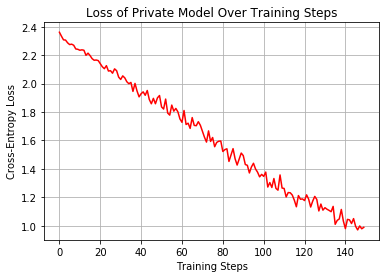

In [12]:
plt.clf()
plt.plot(private_costs, 'r')
plt.title('Loss of Private Model Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Cross-Entropy Loss')
plt.grid()
plt.show()

How about a nonprivate model? Let's set all of our private parameters to zero, and train a regular model from scratch.

In [13]:
%%time

FLAGS = FlagSettings(preserve_privacy=False)
nonprivate_costs, nonprivate_train_acc, nonprivate_test_acc = Train(FLAGS.training_data_path,
                                                                    FLAGS.eval_data_path,
                                                                    FLAGS.network_parameters,
                                                                    FLAGS.num_training_steps,
                                                                    FLAGS.save_path,
                                                                    eval_steps=FLAGS.eval_steps,
                                                                    FLAGS=FLAGS)

Building graph
Selecting Optimizer
Nonprivate SGD Optimizer selected.Initializing variables
Training.
step: 9
train_accuracy: 0.28
eval_accuracy: 0.29
step: 19
train_accuracy: 0.44
eval_accuracy: 0.45
step: 29
train_accuracy: 0.54
eval_accuracy: 0.55
step: 39
train_accuracy: 0.61
eval_accuracy: 0.62
step: 49
train_accuracy: 0.65
eval_accuracy: 0.66
step: 59
train_accuracy: 0.68
eval_accuracy: 0.70
step: 69
train_accuracy: 0.71
eval_accuracy: 0.72
step: 79
train_accuracy: 0.73
eval_accuracy: 0.74
step: 89
train_accuracy: 0.74
eval_accuracy: 0.76
step: 99
train_accuracy: 0.76
eval_accuracy: 0.77
step: 109
train_accuracy: 0.77
eval_accuracy: 0.78
step: 119
train_accuracy: 0.78
eval_accuracy: 0.80
step: 129
train_accuracy: 0.79
eval_accuracy: 0.80
step: 139
train_accuracy: 0.80
eval_accuracy: 0.81
step: 149


CPU times: user 2min 2s, sys: 29.7 s, total: 2min 32s
Wall time: 1min 4s


train_accuracy: 0.81
eval_accuracy: 0.82
Training completed successfully.

## Plot: Training loss of Private vs Nonprivate Models

<Figure size 432x288 with 0 Axes>

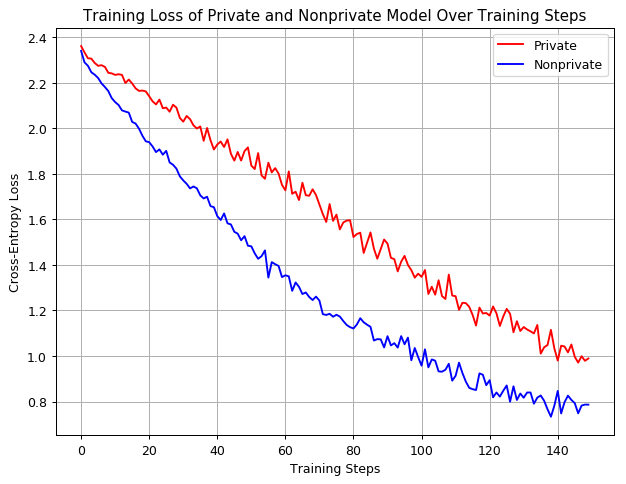

In [14]:
plt.clf()
plt.figure(num=None, figsize=(8,6), dpi=90, facecolor='w', edgecolor='k')
plt.plot(private_costs, 'r')
plt.plot(nonprivate_costs, 'b')
plt.title('Training Loss of Private and Nonprivate Model Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Cross-Entropy Loss')
plt.legend(['Private', 'Nonprivate'])
plt.grid()
plt.show()

As shown above, the nonprivate model obtains a lower loss more quickly. This aspect is due to the added privacy constraints in Private SGD. 

Private SGD does not take the steepest descent, so it does not minimize the loss as quickly as standard SGD.

## Plot: Training Accuracy - Private vs Non-private

<Figure size 432x288 with 0 Axes>

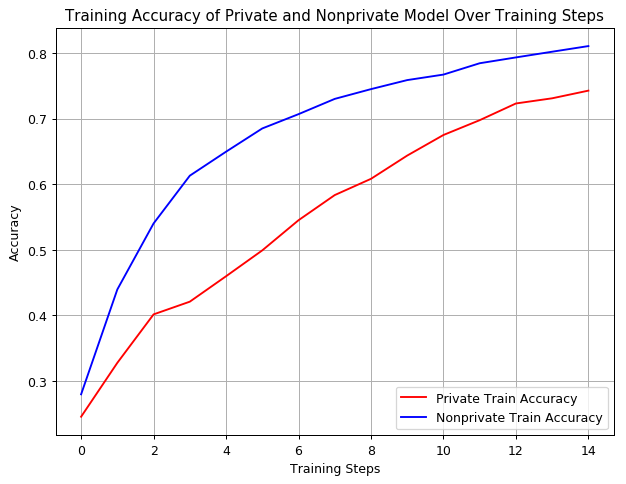

In [15]:
plt.clf()
plt.figure(num=None, figsize=(8,6), dpi=90, facecolor='w', edgecolor='k')
plt.plot(private_train_acc, 'r')
plt.plot(nonprivate_train_acc, 'b')
plt.title('Training Accuracy of Private and Nonprivate Model Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend(['Private Train Accuracy','Nonprivate Train Accuracy'], loc=4)
plt.grid()
plt.show()

This plot reflects the consequences of the previous plot. Since a privately trained model does not minimize loss as quickly as a nonprivately trained model, it is unsurprising that it has diminished training accuracy.

## Plotting Testing Accuracy - Private vs Non-private

<Figure size 432x288 with 0 Axes>

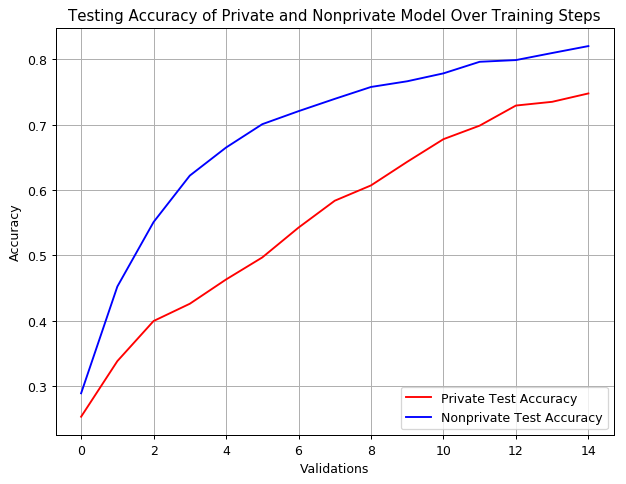

In [16]:
plt.clf()
plt.figure(num=None, figsize=(8,6), dpi=90, facecolor='w', edgecolor='k')
plt.plot(private_test_acc, 'r')
plt.plot(nonprivate_test_acc, 'b')
plt.title('Testing Accuracy of Private and Nonprivate Model Over Training Steps')
plt.xlabel('Validations')
plt.ylabel('Accuracy')
plt.legend(['Private Test Accuracy','Nonprivate Test Accuracy'], loc=4)
plt.grid()
plt.show()

This plot demonstrates that the private model has a lower test accuracy, compared to that of the nonprivate model. 
Once again, we demonstrate that privately trained models have reduced accuracy.

## Plotting (Train - Test) Accuracy - Private vs Nonprivate

<Figure size 432x288 with 0 Axes>

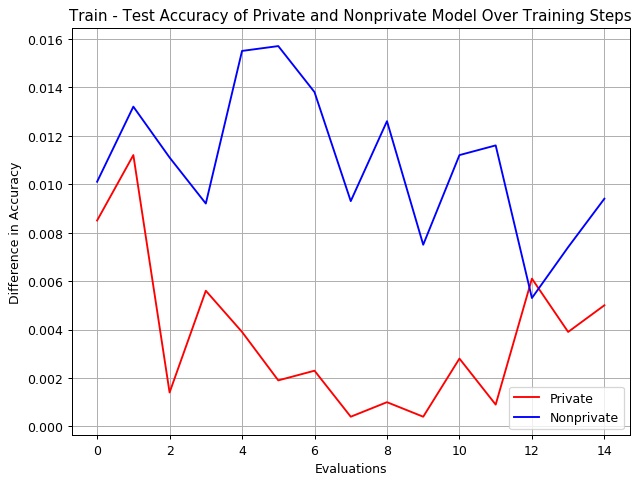

In [17]:
plt.clf()
plt.figure(num=None, figsize=(8,6), dpi=90, facecolor='w', edgecolor='k')
plt.plot([abs(i - j) for i,j in zip(private_train_acc, private_test_acc)], 'r')
plt.plot([abs(i - j) for i,j in zip(nonprivate_train_acc, nonprivate_test_acc)], 'b')
plt.title('Train - Test Accuracy of Private and Nonprivate Model Over Training Steps')
plt.xlabel('Evaluations')
plt.ylabel('Difference in Accuracy')
plt.legend(['Private','Nonprivate'], loc=4)
plt.grid()
plt.show()

This plot demonstrates that the private models can generalize better than nonprivate models. This phenonmenon is reported in Abadi et al., 2016.

# References

    Deep Learning with Differential Privacy: arXiv:1607.00133 [stat.ML] 
    https://arxiv.org/abs/1607.00133

